# Увод у вероватноћу и статистику  
У овом бележнику ћемо се позабавити неким од концепата које смо раније разматрали. Многи концепти из вероватноће и статистике добро су заступљени у главним библиотекама за обраду података у Python-у, као што су `numpy` и `pandas`.  


In [117]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## Случајне променљиве и расподеле  
Хајде да почнемо са узорком од 30 вредности из униформне расподеле од 0 до 9. Такође ћемо израчунати средњу вредност и варијансу.  


In [118]:
sample = [ random.randint(0,10) for _ in range(30) ]
print(f"Sample: {sample}")
print(f"Mean = {np.mean(sample)}")
print(f"Variance = {np.var(sample)}")

Sample: [0, 8, 1, 0, 7, 4, 3, 3, 6, 7, 1, 0, 6, 3, 1, 5, 9, 2, 4, 2, 5, 6, 8, 7, 1, 9, 8, 2, 3, 7]
Mean = 4.266666666666667
Variance = 8.195555555555556


Да бисмо визуелно проценили колико различитих вредности има у узорку, можемо нацртати **хистограм**:


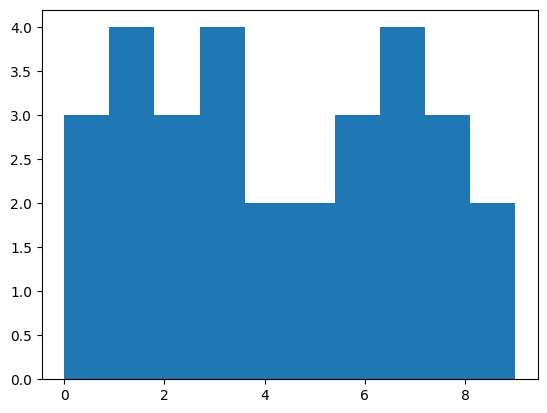

In [119]:
plt.hist(sample)
plt.show()

## Анализа стварних података

Средња вредност и варијанса су веома важни при анализи података из стварног света. Хајде да учитамо податке о бејзбол играчима са [SOCR MLB подаци о висини/тежини](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights)


In [120]:
df = pd.read_csv("../../data/SOCR_MLB.tsv",sep='\t', header=None, names=['Name','Team','Role','Weight','Height','Age'])
df


Empty DataFrame
Columns: [Name, Team, Role, Weight, Height, Age]
Index: []


> Користимо пакет под називом [**Pandas**](https://pandas.pydata.org/) овде за анализу података. О Pandas-у и раду са подацима у Python-у ћемо више говорити касније у овом курсу.

Хајде да израчунамо просечне вредности за године, висину и тежину:


In [121]:
df[['Age','Height','Weight']].mean()

Age        28.736712
Height    201.726306
Weight     73.697292
dtype: float64

Сада се фокусирамо на висину и израчунавамо стандардну девијацију и варијансу:


In [122]:
print(list(df['Height'])[:20])

[180, 215, 210, 210, 188, 176, 209, 200, 231, 180, 188, 180, 185, 160, 180, 185, 197, 189, 185, 219]


In [123]:
mean = df['Height'].mean()
var = df['Height'].var()
std = df['Height'].std()
print(f"Mean = {mean}\nVariance = {var}\nStandard Deviation = {std}")

Mean = 201.72630560928434
Variance = 441.6355706557866
Standard Deviation = 21.01512718628623


Поред средње вредности, има смисла погледати медијану и квартиле. Они се могу визуализовати помоћу **бокс плота**:


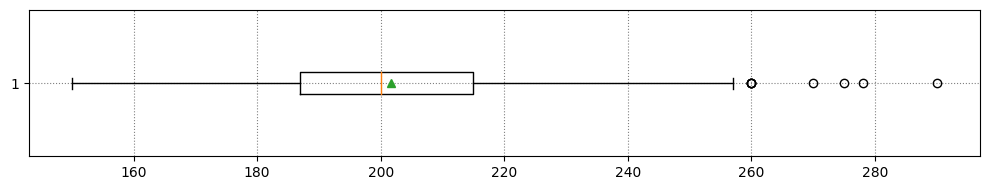

In [124]:
plt.figure(figsize=(10,2))
plt.boxplot(df['Height'], vert=False, showmeans=True)
plt.grid(color='gray', linestyle='dotted')
plt.tight_layout()
plt.show()

Можемо такође направити боксплотове подскупова нашег скупа података, на пример, груписане по улози играча.


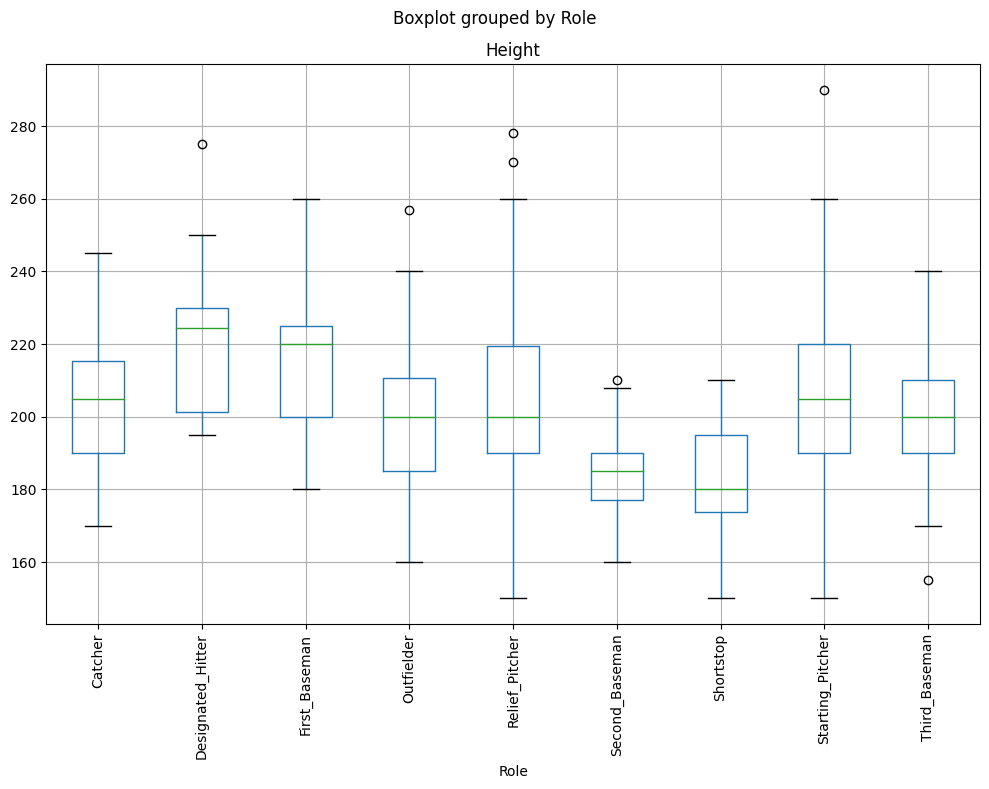

In [125]:
df.boxplot(column='Height', by='Role', figsize=(10,8))
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

> **Напомена**: Овај дијаграм указује на то да су, у просеку, висине првих базмена веће од висина других базмена. Касније ћемо научити како можемо формалније тестирати ову хипотезу и како да покажемо да су наши подаци статистички значајни да би то доказали.  

Године, висина и тежина су све континуиране случајне променљиве. Шта мислите, како изгледа њихова расподела? Добар начин да то сазнате је да нацртате хистограм вредности:


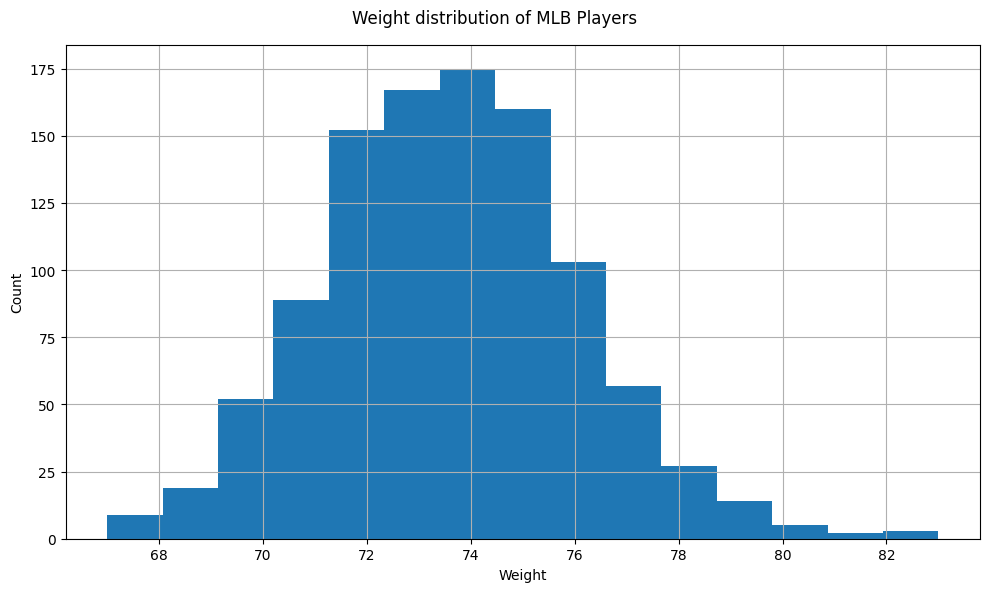

In [126]:
df['Weight'].hist(bins=15, figsize=(10,6))
plt.suptitle('Weight distribution of MLB Players')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Нормална расподела

Хајде да направимо вештачки узорак тежина који прати нормалну расподелу са истим средњим вредностима и варијансом као наши стварни подаци:


In [127]:
generated = np.random.normal(mean, std, 1000)
generated[:20]

array([183.05261872, 193.52828463, 154.73707302, 204.27140391,
       203.88907247, 213.74665656, 225.10092364, 171.75867917,
       204.3521425 , 207.52870255, 158.53001756, 240.94399197,
       189.9909742 , 180.72442994, 173.4393402 , 175.98883711,
       197.86092769, 188.61598821, 234.19796698, 209.0295457 ])

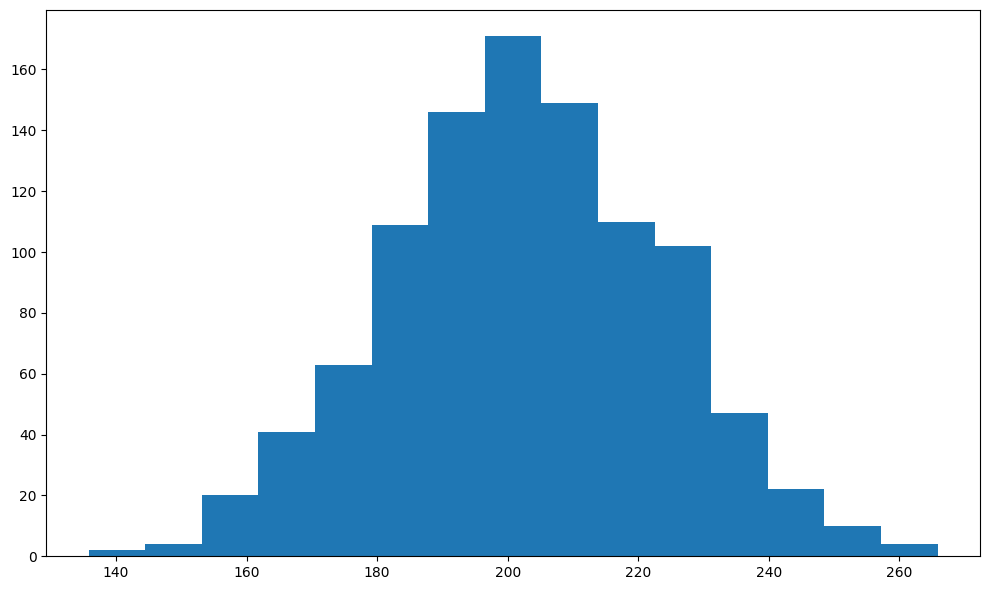

In [128]:
plt.figure(figsize=(10,6))
plt.hist(generated, bins=15)
plt.tight_layout()
plt.show()

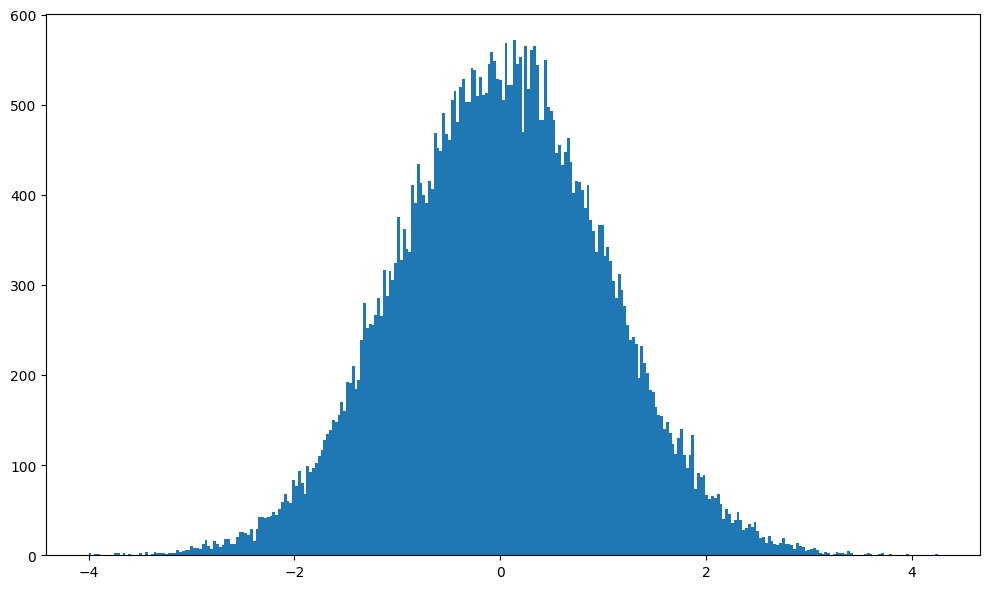

In [129]:
plt.figure(figsize=(10,6))
plt.hist(np.random.normal(0,1,50000), bins=300)
plt.tight_layout()
plt.show()

Пошто је већина вредности у стварном животу нормално расподељена, не бисмо требали користити генератор случајних бројева са равномерном расподелом за генерисање узорака података. Ево шта се дешава ако покушамо да генеришемо тежине са равномерном расподелом (генерисано помоћу `np.random.rand`):


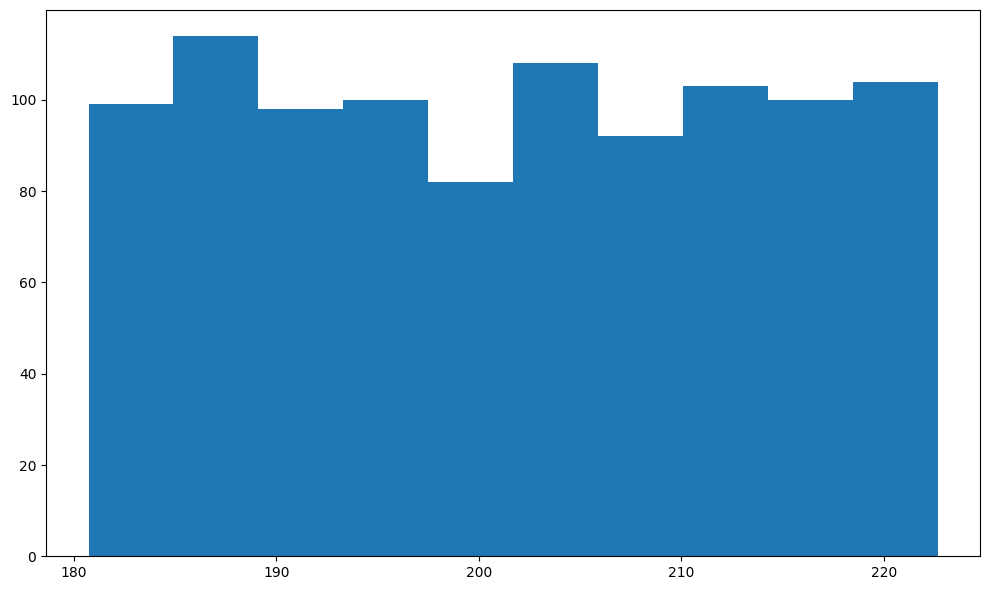

In [130]:
wrong_sample = np.random.rand(1000)*2*std+mean-std
plt.figure(figsize=(10,6))
plt.hist(wrong_sample)
plt.tight_layout()
plt.show()

## Интервали поверења

Хајде сада да израчунамо интервале поверења за тежине и висине бејзбол играча. Користићемо код [из ове дискусије на StackOverflow-у](https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data):


In [131]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

for p in [0.85, 0.9, 0.95]:
    m, h = mean_confidence_interval(df['Weight'].fillna(method='pad'),p)
    print(f"p={p:.2f}, mean = {m:.2f} ± {h:.2f}")

p=0.85, mean = 73.70 ± 0.10
p=0.90, mean = 73.70 ± 0.12
p=0.95, mean = 73.70 ± 0.14


## Тестирање хипотеза

Хајде да истражимо различите улоге у нашем скупу података о бејзбол играчима:


In [132]:
df.groupby('Role').agg({ 'Weight' : 'mean', 'Height' : 'mean', 'Age' : 'count'}).rename(columns={ 'Age' : 'Count'})

Weight      Height  Count
Role                                           
Catcher            72.723684  204.328947     76
Designated_Hitter  74.222222  220.888889     18
First_Baseman      74.000000  213.109091     55
Outfielder         73.010309  199.113402    194
Relief_Pitcher     74.374603  203.517460    315
Second_Baseman     71.362069  184.344828     58
Shortstop          71.903846  182.923077     52
Starting_Pitcher   74.719457  205.321267    221
Third_Baseman      73.044444  200.955556     45

In [133]:
for p in [0.85,0.9,0.95]:
    m1, h1 = mean_confidence_interval(df.loc[df['Role']=='First_Baseman',['Height']],p)
    m2, h2 = mean_confidence_interval(df.loc[df['Role']=='Second_Baseman',['Height']],p)
    print(f'Conf={p:.2f}, 1st basemen height: {m1-h1[0]:.2f}..{m1+h1[0]:.2f}, 2nd basemen height: {m2-h2[0]:.2f}..{m2+h2[0]:.2f}')

Conf=0.85, 1st basemen height: 209.36..216.86, 2nd basemen height: 182.24..186.45
Conf=0.90, 1st basemen height: 208.82..217.40, 2nd basemen height: 181.93..186.76
Conf=0.95, 1st basemen height: 207.97..218.25, 2nd basemen height: 181.45..187.24


Можемо видети да се интервали не преклапају.

Статистички исправнији начин да се докаже хипотеза је коришћење **Студентовог t-теста**:


In [134]:
from scipy.stats import ttest_ind

tval, pval = ttest_ind(df.loc[df['Role']=='First_Baseman',['Height']], df.loc[df['Role']=='Second_Baseman',['Height']],equal_var=False)
print(f"T-value = {tval[0]:.2f}\nP-value: {pval[0]}")

T-value = 9.77
P-value: 1.4185554184322326e-15


Две вредности које враћа функција `ttest_ind` су:
* p-вредност може се сматрати вероватноћом да две дистрибуције имају исти просек. У нашем случају, она је веома ниска, што значи да постоје јаки докази који подржавају да су први базмени виши.
* t-вредност је интермедијарна вредност нормализоване разлике просека која се користи у t-тесту и пореди се са граничном вредношћу за дати ниво поузданости.


## Симулирање нормалне расподеле уз помоћ теореме централног лимита

Псеудо-случајни генератор у Пајтону је дизајниран да нам даје униформну расподелу. Ако желимо да направимо генератор за нормалну расподелу, можемо користити теорему централног лимита. Да бисмо добили вредност са нормалном расподелом, једноставно ћемо израчунати просек узорка генерисаног униформно.


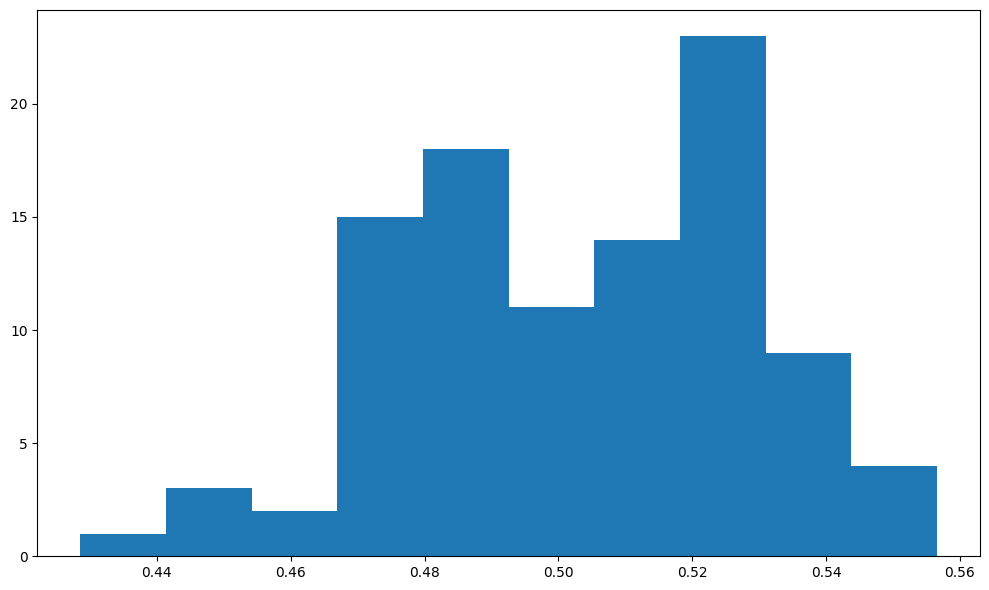

In [135]:
def normal_random(sample_size=100):
    sample = [random.uniform(0,1) for _ in range(sample_size) ]
    return sum(sample)/sample_size

sample = [normal_random() for _ in range(100)]
plt.figure(figsize=(10,6))
plt.hist(sample)
plt.tight_layout()
plt.show()

## Корелација и Зла Бејзбол Корпорација

Корелација нам омогућава да пронађемо односе између низова података. У нашем примерку, претварајмо се да постоји зла бејзбол корпорација која плаћа своје играче у зависности од њихове висине – што је играч виши, то више новца добија. Претпоставимо да постоји основна плата од $1000, и додатни бонус од $0 до $100, у зависности од висине. Узмимо праве играче из MLB-а и израчунајмо њихове замишљене плате:


In [136]:
heights = df['Height']
salaries = 1000+(heights-heights.min())/(heights.max()-heights.mean())*100
print(list(zip(heights, salaries))[:10])

[(180, 1033.985209531635), (215, 1073.6346206518763), (210, 1067.9704190632704), (210, 1067.9704190632704), (188, 1043.0479320734046), (176, 1029.4538482607504), (209, 1066.837578745549), (200, 1056.6420158860585), (231, 1091.760065735415), (180, 1033.985209531635)]


Хајде сада да израчунамо коваријансу и корелацију тих секвенци. `np.cov` ће нам дати такозвану **матрицу коваријансе**, која је проширење коваријансе на више променљивих. Елемент $M_{ij}$ матрице коваријансе $M$ је корелација између улазних променљивих $X_i$ и $X_j$, а дијагоналне вредности $M_{ii}$ су варијанса $X_{i}$. Слично томе, `np.corrcoef` ће нам дати **матрицу корелације**.


In [137]:
print(f"Covariance matrix:\n{np.cov(heights, salaries)}")
print(f"Covariance = {np.cov(heights, salaries)[0,1]}")
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Covariance matrix:
[[441.63557066 500.30258018]
 [500.30258018 566.76293389]]
Covariance = 500.3025801786725
Correlation = 0.9999999999999997


Корелација једнака 1 значи да постоји јака **линеарна веза** између две променљиве. Линеарну везу можемо визуелно видети тако што ћемо једну вредност приказати у односу на другу:


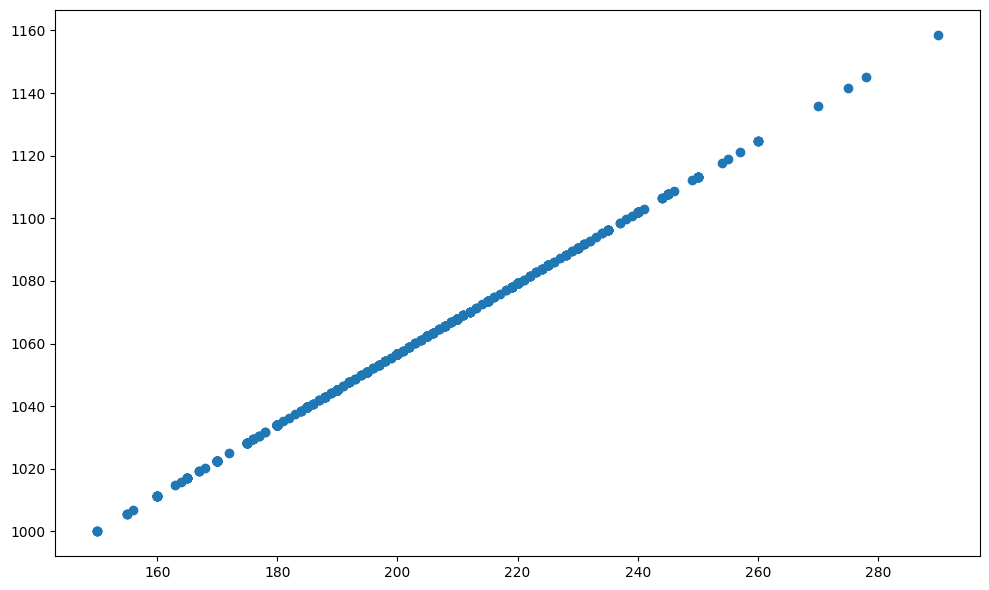

In [138]:
plt.figure(figsize=(10,6))
plt.scatter(heights,salaries)
plt.tight_layout()
plt.show()

Хајде да видимо шта се дешава ако однос није линеаран. Претпоставимо да је наша корпорација одлучила да сакрије очигледну линеарну зависност између висина и плата, и увела неку нелинеарност у формулу, као што је `sin`:


In [139]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.9910655775558532


У овом случају, корелација је нешто мања, али је и даље прилично висока. Сада, да бисмо учинили везу још мање очигледном, можда бисмо желели да додамо мало додатне случајности додавањем неке случајне променљиве плати. Хајде да видимо шта ће се десити:


In [140]:
salaries = 1000+np.sin((heights-heights.min())/(heights.max()-heights.mean()))*100+np.random.random(size=len(heights))*20-10
print(f"Correlation = {np.corrcoef(heights, salaries)[0,1]}")

Correlation = 0.948230287835537


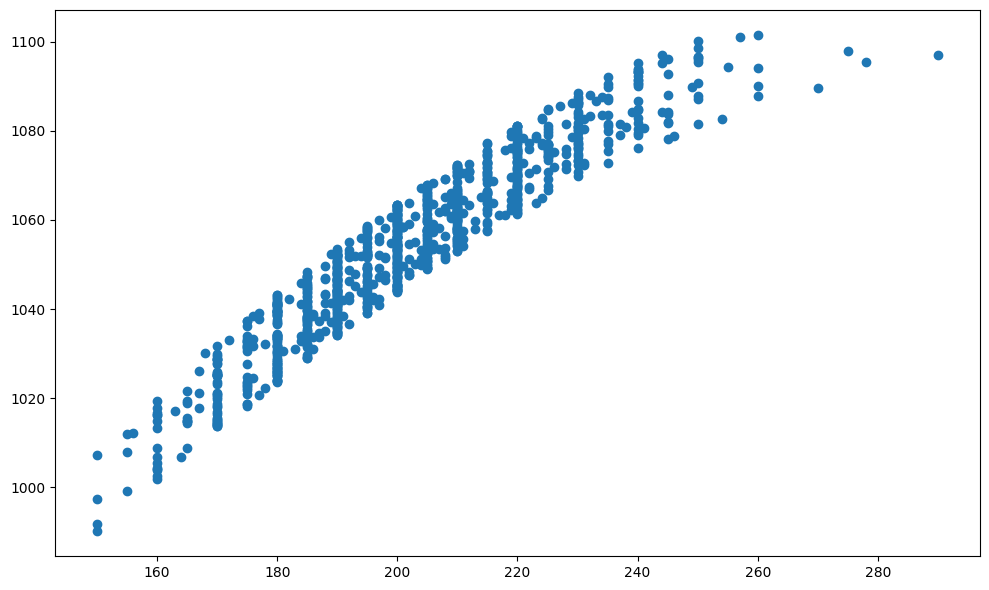

In [141]:
plt.figure(figsize=(10,6))
plt.scatter(heights, salaries)
plt.tight_layout()
plt.show()

> Можете ли да погодите зашто се тачке поређају у вертикалне линије овако?

Приметили смо корелацију између вештачки конструисаног концепта као што је плата и посматране променљиве *висина*. Хајде да видимо да ли се и две посматране променљиве, као што су висина и тежина, такође корелирају:


In [142]:
np.corrcoef(df['Height'],df['Weight'])

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

Нажалост, нисмо добили никакве резултате - само неке чудне `nan` вредности. Ово је због тога што су неке вредности у нашој серији недефинисане, представљене као `nan`, што узрокује да резултат операције такође буде недефинисан. Гледајући матрицу, можемо видети да је `Weight` проблематична колона, јер је само-корелација између вредности `Height` израчуната.

> Овај пример показује важност **припреме података** и **чишћења**. Без одговарајућих података не можемо израчунати ништа.

Хајде да употребимо метод `fillna` како бисмо попунили недостајуће вредности и израчунали корелацију:


In [143]:
np.corrcoef(df['Height'],df['Weight'].fillna(method='pad'))

array([[1.        , 0.52959196],
       [0.52959196, 1.        ]])

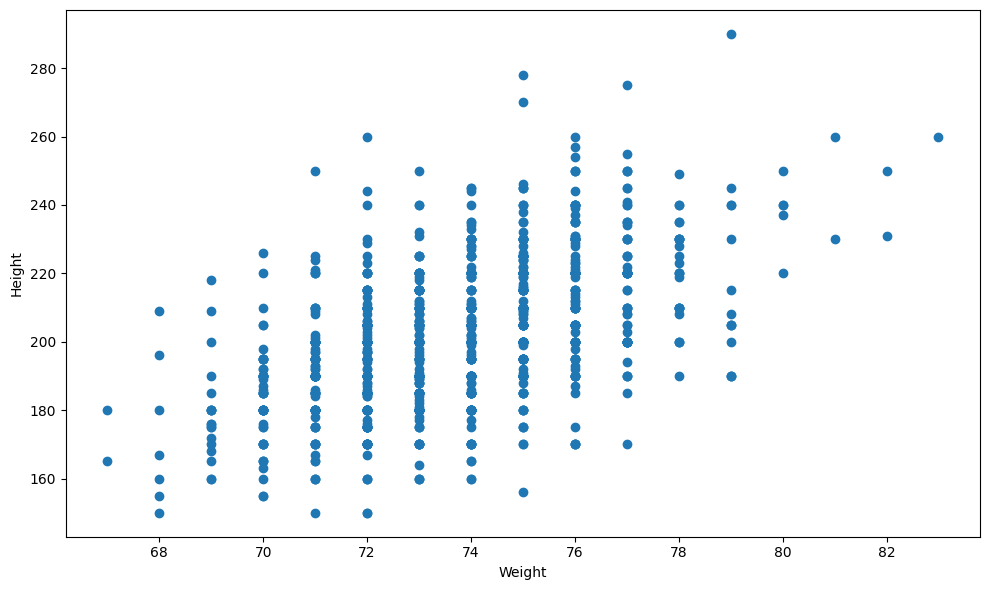

In [144]:
plt.figure(figsize=(10,6))
plt.scatter(df['Weight'],df['Height'])
plt.xlabel('Weight')
plt.ylabel('Height')
plt.tight_layout()
plt.show()

## Закључак

У овом бележнику смо научили како да изводимо основне операције над подацима ради израчунавања статистичких функција. Сада знамо како да користимо поуздан апарат математике и статистике како бисмо доказали одређене хипотезе, као и како да израчунамо интервале поверења за произвољне променљиве на основу узорка података.



---

**Одрицање од одговорности**:  
Овај документ је преведен коришћењем услуге за превођење помоћу вештачке интелигенције [Co-op Translator](https://github.com/Azure/co-op-translator). Иако тежимо тачности, молимо вас да имате у виду да аутоматски преводи могу садржати грешке или нетачности. Оригинални документ на изворном језику треба сматрати ауторитативним извором. За критичне информације препоручује се професионални превод од стране људи. Не сносимо одговорност за било каква погрешна тумачења или неспоразуме који могу произаћи из коришћења овог превода.
